In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')

plt.style.use("dark_background")


# Import data

* https://fred.stlouisfed.org

<AxesSubplot:xlabel='DATE'>

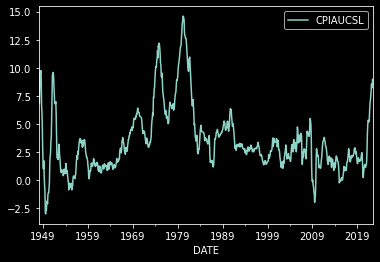

In [2]:
inflation=pd.read_csv('data/inflation.csv',index_col='DATE',parse_dates=True).pct_change(12).dropna()*100
inflation.plot()

In [3]:
inflation.tail()

,CPIAUCSL
DATE,
2022-04-01,8.224139
2022-05-01,8.516413
2022-06-01,8.995221
2022-07-01,8.482130
2022-08-01,8.249235


<AxesSubplot:xlabel='DATE'>

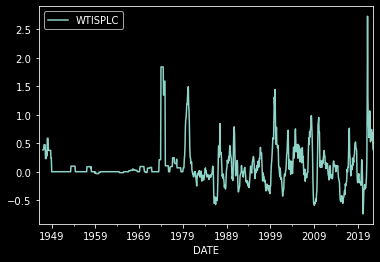

In [4]:
oil=pd.read_csv('data/oil.csv',index_col='DATE',parse_dates=True)
oil['WTISPLC']=pd.to_numeric(oil['WTISPLC'], errors='coerce')
oil=oil.pct_change(12)
oil.plot()

<AxesSubplot:xlabel='DATE'>

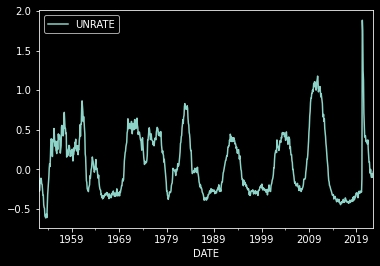

In [5]:
unemployment=pd.read_csv('data/unemployment.csv',index_col='DATE',parse_dates=True)
unemployment['UNRATE']=pd.to_numeric(unemployment['UNRATE'], errors='coerce').dropna()
unemployment=unemployment.pct_change(48).dropna()
unemployment.plot()

<AxesSubplot:xlabel='DATE'>

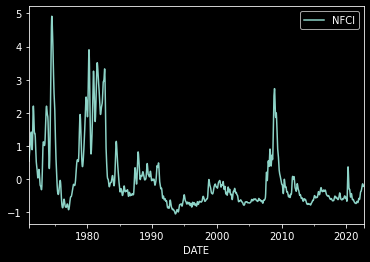

In [6]:
fincond=pd.read_csv('data/fincond.csv',index_col='DATE',parse_dates=True)
fincond['NFCI']=pd.to_numeric(fincond['NFCI'], errors='coerce').dropna()

fincond.plot()

<AxesSubplot:xlabel='DATE'>

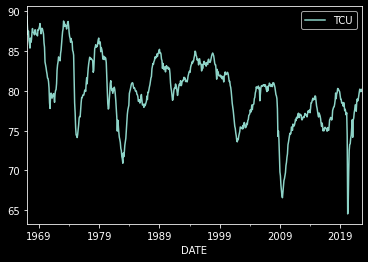

In [7]:
capacity=pd.read_csv('data/capacity.csv',index_col='DATE',parse_dates=True)
capacity['TCU']=pd.to_numeric(capacity['TCU'], errors='coerce').dropna()

capacity.plot()

<AxesSubplot:xlabel='DATE'>

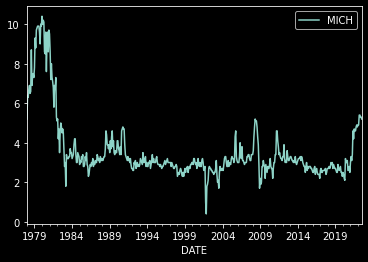

In [8]:
expected=pd.read_csv('data/expected.csv',index_col='DATE',parse_dates=True)
expected['MICH']=pd.to_numeric(expected['MICH'], errors='coerce').dropna()

expected.plot()

<AxesSubplot:xlabel='DATE'>

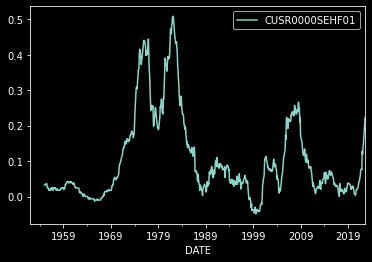

In [9]:
elec=pd.read_csv('data/electricity.csv',index_col='DATE',parse_dates=True).pct_change(36)
elec['CUSR0000SEHF01']=pd.to_numeric(elec['CUSR0000SEHF01'], errors='coerce').dropna()

elec.plot()

#  Data Cleaning

In [10]:
a=[]
for x in [expected,inflation,unemployment,oil]: a.append(x.resample('MS').ffill())

In [11]:
df=pd.concat(a,axis=1).ffill()
df=df['1978':]
df.head()

,MICH,CPIAUCSL,UNRATE,WTISPLC
DATE,,,,
1978-01-01,5.2,6.814310,0.254902,0.068345
1978-02-01,6.4,6.239460,0.211538,0.068345
1978-03-01,6.3,6.375839,0.235294,0.068345
1978-04-01,6.7,6.500000,0.196078,0.068345
1978-05-01,6.9,7.142857,0.176471,0.068345


In [12]:
forecast_windows=6 ## MONTHS AHEAD FOR PREDICTION
df['Ahead Inflation']=inflation.shift(-forecast_windows).resample('MS').ffill()

In [13]:
df=df.dropna(thresh=4,axis=0)
df

,MICH,CPIAUCSL,UNRATE,WTISPLC,Ahead Inflation
DATE,,,,,
1978-01-01,5.2,6.814310,0.254902,0.068345,7.730263
1978-02-01,6.4,6.239460,0.211538,0.068345,7.855974
1978-03-01,6.3,6.375839,0.235294,0.068345,8.482871
1978-04-01,6.7,6.500000,0.196078,0.068345,8.928571
1978-05-01,6.9,7.142857,0.176471,0.068345,8.870968
...,...,...,...,...,...
2022-04-01,5.4,8.224139,-0.100000,0.649060,NaN
2022-05-01,5.3,8.516413,-0.052632,0.680988,NaN
2022-06-01,5.3,8.995221,-0.100000,0.608854,NaN


In [14]:
split_date='2010-01-01'
df_train=df[df.index < split_date]
df_test=df[df.index > split_date]
split_date=df_train.index[-1]
split_date

Timestamp('2009-12-01 00:00:00', freq='MS')

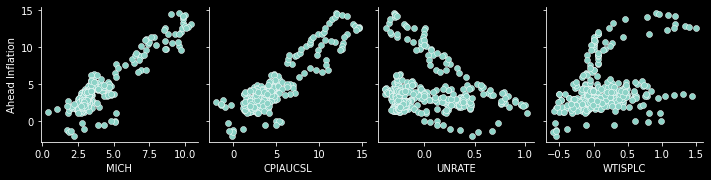

In [15]:
sns.pairplot(data=df_train,x_vars=df.columns[:-1],y_vars=df.columns[-1])

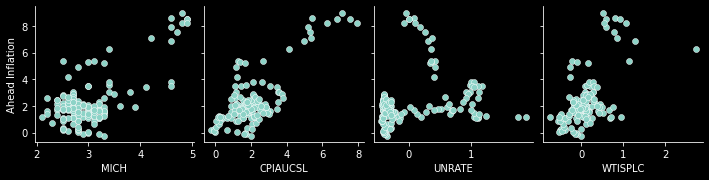

In [16]:
sns.pairplot(data=df_test,x_vars=df.columns[:-1],y_vars=df.columns[-1])

# Model Fitting

In [17]:
from xgboost import  XGBRegressor

In [18]:
import itertools
parameters={'random_state': [100],'max_depth': [2,4,6,8],'n_estimators': [50,100,200,300],'eta':[0.1,0.2,0.3]}
parameters_=list((dict(zip(parameters, x)) for x in itertools.product(*parameters.values())))

In [19]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import explained_variance_score

from sklearn.metrics import r2_score

acc=[]
accuracy=[]
for param in parameters_:
    tscv = TimeSeriesSplit(n_splits=3)
    model = XGBRegressor(**param)
    for train_index, test_index in tscv.split(df_train):
        X_train, X_test = df_train.iloc[train_index,:-1], df_train.iloc[test_index,:-1]
        y_train, y_test = df_train.iloc[train_index,-1], df_train.iloc[test_index,-1]
        model.fit(X_train, y_train)
        
        y_pr = model.predict(X_test)

        # scoring
        acc.append(r2_score(y_test,y_pr))
    accuracy.append(np.mean(acc))

best_param = parameters_[np.argmax(accuracy)]
best_param

{'random_state': 100, 'max_depth': 2, 'n_estimators': 50, 'eta': 0.1}

# Model Evaluation

In [20]:
X,y=df_test.iloc[:,:-1],df_test.iloc[:,-1] 
predicted=[]
roll=12
for i in range(roll+forecast_windows,len(df_test)):
    model = XGBRegressor(**best_param)

    X_fit = X.iloc[i-roll-forecast_windows:i-forecast_windows]
    y_fit = y.iloc[i-roll-forecast_windows:i-forecast_windows]

    model = model.fit(X_fit, y_fit)

    X_predict = X.iloc[i:i+ 1]
    y_pred = model.predict(X_predict)
    predicted.append(y_pred)

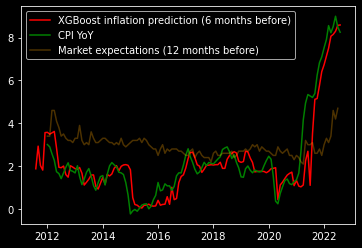

In [21]:
predicted_df=pd.DataFrame(predicted,index=df_test.iloc[forecast_windows+roll:].index)
plt.plot(predicted_df,label='XGBoost inflation prediction (6 months before)',color='red')
plt.plot(inflation['2012':],label='CPI YoY',color='green')
plt.plot(expected['2011':].shift(12), label='Market expectations (12 months before)',alpha=0.3,color='orange')
plt.legend()
plt.show()

In [22]:
df['Actual Inflation']=inflation

In [23]:
y_actual=df.loc[df_test.index]['Actual Inflation'].iloc[roll+forecast_windows:].ffill()

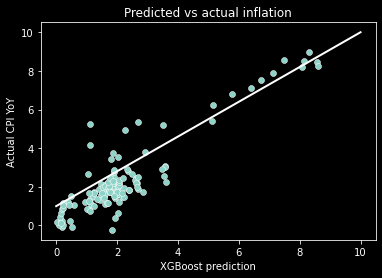

In [24]:
#sns.scatterplot(x=expected.loc[df_test.index].iloc[:,0],y=df_test['CORESTICKM159SFRBATL'],label='Market expectation')
sns.scatterplot(x=predicted_df.iloc[:,0],y=y_actual,label='')
plt.plot([0, 10], [1, 10], linewidth=2,color='white')
plt.xlabel('XGBoost prediction')
plt.ylabel('Actual CPI YoY')

plt.title('Predicted vs actual inflation')
plt.show()

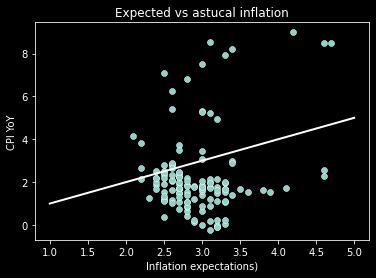

In [25]:
#sns.scatterplot(x=expected.loc[df_test.index].iloc[:,0],y=df_test['CORESTICKM159SFRBATL'],label='Market expectation')
sns.scatterplot(x=expected.iloc[:,0].shift(12),y=y_actual,label='')
plt.plot([1, 5], [1, 5], linewidth=2,color='white')
plt.xlabel('Inflation expectations)')
plt.ylabel('CPI YoY')

plt.title('Expected vs astucal inflation')
plt.show()

In [26]:
print('Explained Variance: ', "{:.2%}".format(explained_variance_score(y_actual,predicted_df)))

print('R2: ', "{:.2%}".format(r2_score(y_actual,predicted_df)))

from sklearn.metrics import mean_absolute_error
print('Mean Abs Error: ', "{:.2%}".format(mean_absolute_error(y_actual,predicted_df)/100))

from sklearn.metrics import mean_squared_error
print('RMSE: ', "{:.2%}".format(mean_squared_error(y_actual,predicted_df,squared=False)/100))

from sklearn.metrics import max_error
print('Max Error: ', "{:.2%}".format(max_error(y_actual,predicted_df)/100))



Explained Variance:  82.56%
R2:  81.83%
Mean Abs Error:  0.57%
RMSE:  0.84%
Max Error:  4.17%


In [27]:
model = XGBRegressor(**best_param)

X_fit = df.iloc[-forecast_windows-roll:-forecast_windows,:-2]
y_fit = df.iloc[-forecast_windows-roll:-forecast_windows,-2].ffill()

model = model.fit(X_fit, y_fit)

y_pred = model.predict(np.array(df.iloc[-6:,:-2]))

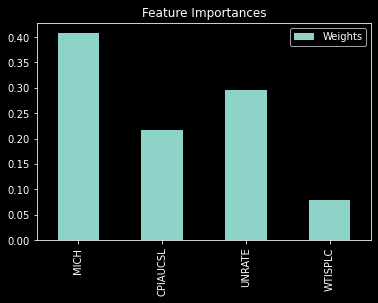

In [28]:
pd.DataFrame(model.feature_importances_,X.columns,['Weights']).plot.bar()
plt.title('Feature Importances')
plt.show()

In [29]:
print('Expected inflation in march 2023: ', "{:.2%}".format(y_pred[-1]/100))

Expected inflation in march 2023:  8.40%


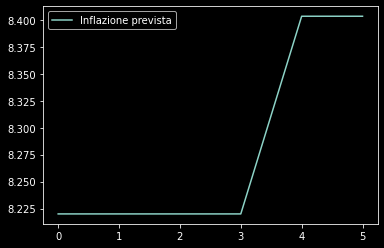

In [30]:
pd.DataFrame(y_pred,columns=['Inflazione prevista']).plot()
plt.legend()
plt.show()